![STScI Logo](../../../_static/stsci_header.png)

<a id="top"></a>
# Plannning WFC Imaging While Taking into Account CTE-related Losses

***

## Learning Goals

By the end of this tutorial, you will:

- Learn how to estimate the degree to which degraded CTE will artificially reduce source brightness
- Understand how to adjust exposure times to account for artificially dimmed point sources
- Understand how to adjust exposure times to account for artificially dimmed extended sources



## Table of Contents

[Introduction](#intro) <br>
[Imports](#imports) <br>
[1. Estimating Signal-to-Noise Ratio and Exposure Time for a Point Source](#section1) <br>
 - [1a. Estimating the real source brightness and SNR using the photometric CTE correction formula](#section1a) <br>
 - [1b. Approaches to increase the SNR](#section1b) <br>
    - [Option 1: Place the target closer to the serial register](#opt1) <br>
    - [Option 2: Apply post-flash](#opt2)
    - [Option 3: Increase exposure time](#opt3)

[2. Estimating SNR of an extended source affected by degraded CTE](#section2) <br>
[Additional Resources](#additional) <br>
[About this Notebook](#about) <br>
[Citations](#citations)

<a id="intro"></a>
## Introduction

The <a href="https://etc.stsci.edu/etc/input/acs/imaging/">ACS Imaging Exposure Time Calculator (ETC)</a> is a powerful tool for users to determine the exposure time to reach a given signal-to-noise, or vice versa. However, the ETC does not take into account the impact that degraded Charge Transfer Efficiency (CTE) has on the measured brightnesses of targets. In reality, the degraded CTE of the WFC detectors leads to sources being fainter than expected, and this effect increases for fainter backgrounds, fainter sources, and increased number of pixel transfers during the read-out process (see e.g., <a href="https://ui.adsabs.harvard.edu/abs/2022acs..rept....6C/abstract">ACS ISR 2022-06</a>). This tutorial will guide you through the steps needed to assess the impact of degraded CTE and how to adjust exposure times to recover a desired signal-to-noise ratio (SNR). Throughout, we assume users are working with the FLT products produced by the ACS calibration pipeline.

This tutorial makes extensive use of the ACS Imaging ETC v34.1 which assumes an observation date of April 1, 2027. Output from specific ETC runs are linked throughout.

<a id="imports"></a>
## Imports
- *numpy* to handle array functions
- *matplotlib.pyplot* for plotting data
- *acstools.acsphotcte* for estimating the impact of degraded CTE on source brightness

In [18]:
%matplotlib inline
from acstools import acsphotcte
import numpy as np
import matplotlib.pyplot as plt 

***

<a id="section1"></a>

## 1. Estimating Signal-to-Noise Ratio and Exposure Time for a Point Source

In this first example, our goal is to estimate the exposure time needed to obtain SNR = 10 for a V = 23 mag (Vega system) B5V star using the F658N narrow-band filter. We'll assume default sky backgrounds, and assume we are measuring brightness using a five pixel (0.25 arcsecond) radius circular aperture.

Set up the <a href="https://etc.stsci.edu/etc/input/acs/imaging/">ETC</a> with the following parameters:

* Filter Wheel 1: H-alpha (F658N)
* Filter Wheel 2: WFC Clear (CLEAR2L)
* \# Frames: 1
* Exposure parameters --> Exposure time needed to obtain a SNR of 10.0
* Exposure Parameters --> Point Source --> Use a circular region of radius (arcsec): 0.25
* Spectral Distributions --> Castelli and Kurucz Models: B5V 15000 4.0
* Normalize the target's flux: 23 Vega magnitude in Johnson/V

<a href="https://etc.stsci.edu/etc/results/ACS.im.2252187/">The ETC tells us we need a total time of 1436 seconds to reach this SNR in a single exposure (# frames = 1)</a>, but we need multiple exposures to remove image defects. Let's assume we are doing a two-point line dither, so we set # frames = 2, and get <a href="https://etc.stsci.edu/etc/results/ACS.im.2252188/">a total time of 1742 seconds, or 2x871 seconds.</a> 

However, the real SNR measured in this exposure time will be less than 10 due to degraded CTE. This is especially true because the ETC warns us that the background level is only 19e-, well below the recommended minimum background level of 30e- (although degraded CTE still has an impact at a background of 30e-).

<a id="section1a"></a>
### 1a. Estimating the real source brightness and SNR using the photometric CTE correction formula

The specific degree to which sources are dimmed is discussed in <a href="https://ui.adsabs.harvard.edu/abs/2022acs..rept....6C/abstract">ACS ISR 2022-06</a>, which also provides a formula to estimate the true brightness in counts, C<sub>true</sub>, as a function of the measured (artificially dimmed by degraded CTE) brightness, C<sub>meas</sub>, background, location on the detector, and date. For our purposes, we actually want to invert this formula to estimate C<sub>meas</sub> as a function of C<sub>true</sub> (and the other parameters), but this is not trivial due to its complex form. One workaround is to generate a curve of C<sub>true</sub> vs. C<sub>meas</sub> (with all other parameters fixed) and then interpolate to estimate C<sub>meas</sub>. Below, we define a function to do all this for us in one line.

In [19]:
def estimate_uncorrected_brightness(radius, ytransfers, mjd, background, 
                                    true_counts, array_min=100, array_max=1000,
                                    array_size=101, plot=True):
    '''
    Estimates the measured brightness of an object after it has been artificially
    dimmed by degraded CTE. Uses the photometric CTE correction formula of
    ACS ISR 2022-06.
       
    Parameters
    ----------
    radius : {3, 5}
        Aperture radius used to extract photometry
    
    ytransfers : float
        Number of row transfers during readout. For chip 2 on WFC, this is the Y
        value. For chip 1, this is ``2048-Y``.
    
    mdj : float
        MJD of the observation
        
    background : float
        Local sky background in e- per pixel
    
    true_counts : float
        True source brightness in e-, i.e.
    
    array_min : float, optional
        Minimum measured brightness in the array used for interpolation. Default
        is 100
        
    array_max : float, optional
        Maximum measured brightness in the array used for interpolation. Default
        is 1000
        
    array_size: int, optional
        Size of measured brightness array used for interpolation. Default is 101
        
    plot: bool, optional
        Flag to turn on plotting. Default is True.
        
    Returns
    -------
    measured_brightness : float
        The expected meassured brightness of the source after artificially being
        dimmed by degraded CTE.
    
    delta_mag : float
        The magnitude difference between the true brightness and the measured
        brightness
    
    
    '''
    
    # initialize the photCTE API
    photctecalc = acsphotcte.PhotCTEAPI()

    # generate an array of measured (uncorrected) brightnesses. The range be
    # adjusted with the parameters above
    measured_flux_array = np.linspace(array_min, array_max, array_size) 

    # apply the photCTE correction to get the corrected "true" brightnesses. Some
    # inputs need to be converted onto arrays
    y_transfers_array = np.zeros(len(measured_flux_array)) + ytransfers
    local_skys_array = np.zeros(len(measured_flux_array)) + background
    cte_corrected_magnitudes = photctecalc.correct_photometry(radius=radius, 
                                                              ytransfers=y_transfers_array, 
                                                              mjd=mjd, 
                                                              local_skys=local_skys_array, 
                                                              fluxes=measured_flux_array,
                                                              )

    # The corrected brightnesses come out as magnitudes. Convert back to counts
    true_flux_array = 10 ** (cte_corrected_magnitudes / -2.5)

    # interpolate along this curve to get the measured brightness at the input true brightness
    # (i.e., what the ETC told us we would get)
    measured_brightness = np.interp(true_counts, true_flux_array, measured_flux_array)

    if plot:
        # Plot the measured (CTE-impacted) vs. expected true brightness. Interpolate
        # to get the CTE-impacted brightness for the target we put into the ETC.
        fig, ax = plt.subplots()
        ax.plot(true_flux_array, measured_flux_array, label='measured vs. true flux trend')
        ax.set_xlabel('True brightness [e-]')
        ax.set_ylabel('Measured brightness [e-]')
        ax.axline(xy1=(array_min, array_min), slope=1, color='red', ls='--', label='1-to-line')
        ax.scatter(true_counts, measured_brightness, color='orange', s=50, label='our target')
        ax.legend()

    # print some useful output
    
    print(f'A {true_counts:.1f} e- source on a background of {background:.1f}e-/pixel '
          f'undergoing {ytransfers} pixel transfers will have a measured brightness of {measured_brightness:.1f}e-')

    # calculate effective difference in magnitude of expected vs measured source brightness
    delta_mag = -2.5 * np.log10(measured_brightness) - (-2.5 * np.log10(true_counts))
    print(f'This corresponds to an effective magnitude difference of {delta_mag:.2f} mags due to CTE losses.')
    
    return measured_brightness, delta_mag

Next, we apply this function to estimate the CTE-affected measured brightness (C<sub>meas</sub>) for our expected "true" brightness (C<sub>true</sub>). We need to assume a date of our observations and number of y transfers during readout (related to where the object sits on the detector). Let's assume our star lies at the center of one of the WFC detectors, so undergoes 1024 pixel transfers during readout. We'll assume our observations take place on April 1, 2026 (mjd = 60766). We'll add these parameters as variables, along with the <a href="https://etc.stsci.edu/etc/results/ACS.im.2252188/">total source counts, background counts, aperture area, and number of frames from the ETC output</a>. 

In [20]:
# define number of y transfers and date of observations
y_transfers = 1024  # pixels
mjd = 61496  # April 1, 2027

# place ETC output here:
source_counts = 847.23
background_counts = 3122.79
aperture_area = 80.30  # in pixels
n_frames = 2

expected source counts per exposure = 423.6
background per pixel per exposure = 19.4
A 423.6 e- source on a background of 19.4e-/pixel undergoing 1024 pixel transfers will have a measured brightness of 302.5e-
This corresponds to an effective magnitude difference of 0.37 mags due to CTE losses.


(np.float64(302.5036819209198), np.float64(0.3656016620770126))

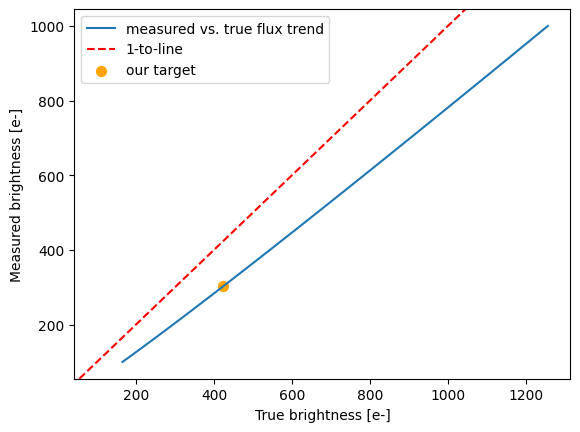

In [21]:
# get source and background counts per exposure
c_true = source_counts / n_frames  # in e-
background_per_exposure = background_counts / n_frames / aperture_area  # in e-/pixel

print(f'expected source counts per exposure = {c_true:.1f}')
print(f'background per pixel per exposure = {background_per_exposure:.1f}')

# now run the function to estimate the CTE-impacted measured brightness
aperture_radius = 5  # aperture radius in pixels. Can be 3 or 5.
estimate_uncorrected_brightness(aperture_radius, y_transfers, mjd, 
                                background_per_exposure, c_true)

The ETC predicts we'll have 423.6 counts per exposure, but in reality, we should have more like 302.5 counts per exposure. In other words, our V = 23 mag star will actually look more like a V = 23.37 mag star.

To estimate the SNR given this artificial dimming, we can replace V = 23 mag with V = 23.37 mags under "Normalize the target's flux", and tell the ETC to calculate the SNR reached in an exposure time of 1742 seconds under "Specify the exposure parameters".

We get an <a href="https://etc.stsci.edu/etc/results/ACS.im.2252288/">expected SNR of about 7.2</a>.

<a id="section1b"></a>

### 1b. Approaches to increase the SNR

If a SNR of 7.2 is not satisfactory, users can explore a few options:
1) Move the source closer to the serial registers
2) Apply post-flash to increase the background
3) Increase exposure time

We discuss each of these options below.

<a id="opt1"></a>

#### Option 1: Place the target closer to the serial register

Moving the target close to the serial registers equates to lowering the number of pixel transfers for readout. This means fewer opportunities for charge to get trapped, reducing the overall dimming effect caused by degraded CTE. For example, let's rerun our calculations assuming the source is placed only 100 pixels from the serial registers.

A 423.6 e- source on a background of 19.4e-/pixel undergoing 100 pixel transfers will have a measured brightness of 411.2e-
This corresponds to an effective magnitude difference of 0.03 mags due to CTE losses.


(np.float64(411.2370304320248), np.float64(0.0321977886034821))

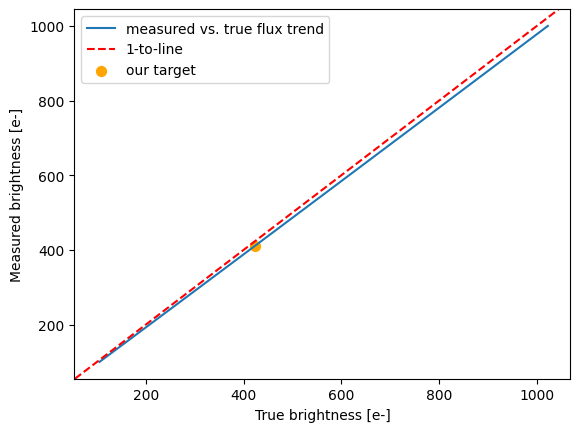

In [22]:
estimate_uncorrected_brightness(aperture_radius, 100, mjd, 
                                background_per_exposure, c_true)

We estimate only ~10 e- are lost during readout, equating to 0.03 mags. Plugging in an apparent target brightness of V = 23.03 mags to the ETC, <a href="https://etc.stsci.edu/etc/results/ACS.im.2252192/">we estimate an SNR of 9.7 in 1742 seconds</a>, pretty close to our desired SNR of 10. 

<a id="opt2"></a>

#### Option 2: Apply post-flash

Maybe you cannot move your target for whatever reason. You could consider applying post-flash. This is generally not recommeded if the background can be increased via other means (see the next section), but can be done for compact sources if need be. Generally, post-flash will have the biggest impact on extremely weak sources. For sources with brightnesses of a few hundred e- like we are considering here, any gains in recovered counts and SNR obtained by raising the background with post-flash will be typically be outweighed by the added noise, lowering the overall SNR (see Figure 5 of <a href="https://ui.adsabs.harvard.edu/abs/2024acs..rept....2S/abstract">ACS ISR 2024-02</a>). To test this likelihood, let's recalculate the expected measured brightness assuming we use post-flash to increase our background to the minimum recommended 30e-. 

A 423.6 e- source on a background of 30.0e-/pixel undergoing 1024 pixel transfers will have a measured brightness of 314.5e-
This corresponds to an effective magnitude difference of 0.32 mags due to CTE losses.


(np.float64(314.5017230898439), np.float64(0.3233707516639308))

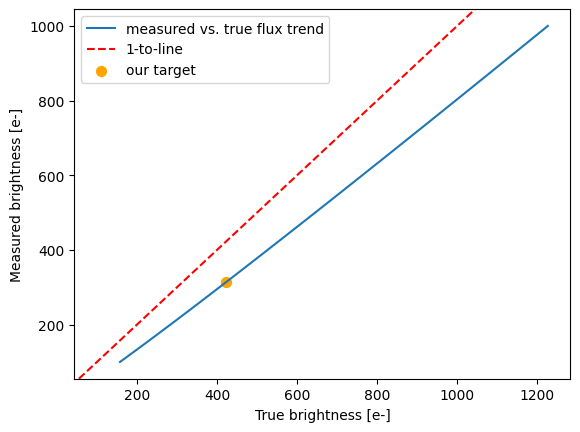

In [23]:
estimate_uncorrected_brightness(aperture_radius, y_transfers, mjd, 
                                30, c_true)

Our target still looks 0.32 mags dimmer than we expect. Set the target brightness to V = 23.32 mags and Post Flash to 11 e-. Then have the ETC calculate the SNR in 1742 seconds. <a href="https://etc.stsci.edu/etc/results/ACS.im.2252290/">We get SNR = 6.7</a>, so actually slightly worse than if we never did post-flash in the first place.

<a id="opt3"></a>

#### Option 3: Increase exposure time

Let's explore the last option of simply increasing our exposure time. This process will likely be iterative, because once we adjust the time of individual exposures, the degree to which degraded CTE impacts source brightness can change (because the source and background counts change). As a starting point, we can use the ETC to see how long we would need to detect our artificially dimmed V = 23.37 mag star at SNR = 10. In the ETC, set the source brightness to V = 23.37 and makes sure post-flash is set back to 0 e-. The ETC says <a href="https://etc.stsci.edu/etc/results/ACS.im.2252291/">we need 2759 seconds to reach SNR = 10</a>, but we should probably divide this into three exposures. Setting # frames = 3 and rerunning the ETC, it tells us <a href="https://etc.stsci.edu/etc/results/ACS.im.2252292/">we need 3088 seconds</a>, or 3x1029 seconds. We get a warning that the background is only 23e-.

Let's again go through the process of calculating the measured brightness given the true brightness and background. First, rerun the ETC using this exposure time our original brightness of V = 23 mags and new time of 3088 seconds to get the true source and background counts in this three-exposure setup (<a href="https://etc.stsci.edu/etc/results/ACS.im.2252293/">it should be 1502 and 5536 over all exposures</a>).

expected source counts per exposure = 500.7
background per pixel per exposure = 23.0
A 500.7 e- source on a background of 23.0e-/pixel undergoing 1024 pixel transfers will have a measured brightness of 370.2e-
This corresponds to an effective magnitude difference of 0.33 mags due to CTE losses.


(np.float64(370.2002472199651), np.float64(0.32777993377342085))

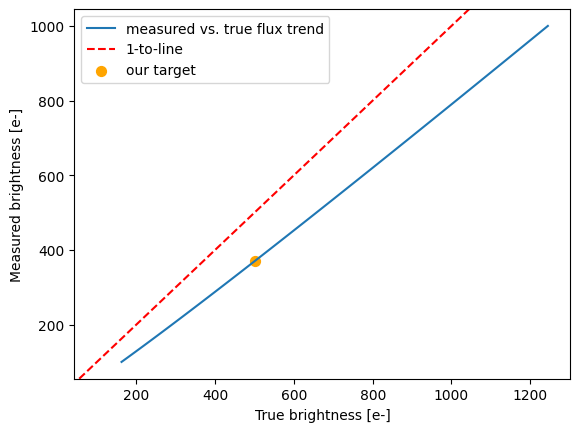

In [24]:
# define number of y transfers and date of observations
y_transfers = 1024  # pixels
mjd = 61496  # April 1, 2027

# place ETC output here:
source_counts = 1502
background_counts = 5536
aperture_area = 80.30  # in pixels
n_frames = 3

# get source and background counts per exposure
c_true = source_counts / n_frames  # in e-
background_per_exposure = background_counts / n_frames / aperture_area  # in e-/pixel

print(f'expected source counts per exposure = {c_true:.1f}')
print(f'background per pixel per exposure = {background_per_exposure:.1f}')

# now run the function to estimate the CTE-impacted measured brightness
aperture_radius = 5  # aperture radius in pixels. Can be 3 or 5.
estimate_uncorrected_brightness(aperture_radius, y_transfers, mjd, 
                                background_per_exposure, c_true)

This tells us our V = 23 star looks like a V = 23.30 star. Plug that into the ETC with our exposure time, and see that <a href="https://etc.stsci.edu/etc/results/ACS.im.2252294/">the predicted SNR is 10.35</a>, close to our desired SNR = 10. It is slightly higher because the exposure times in this three-exposure setup are slightly longer than the exposure times of our two-exposure setup, meaning source and background counts per exposure are slightly higher, meaning artificial dimming from degraded CTE is slightly less severe. One could iterate further, possibly reducing exposure times a bit a still obtain SNR ~ 10, but for the purposes of this example, we will stop here.

<a id="section2"></a>

## 2. Estimating SNR of an extended source affected by degraded CTE

It was shown in <a href="https://ui.adsabs.harvard.edu/abs/2025acs..rept....2S/abstract">ACS ISR 2025-02</a> that degraded CTE can impact extended sources like galaxies as well as point sources. Integrated brightnesses (e.g. using large apertures) are generally reliable as long as backgrounds are above 20e-/pixel and targets are brighter than ~300 e- per exposure, but brightness measurements on smaller scales suffer measurable losses. ***At this point, there is no correction formula for extended sources like there is for point sources***, but preliminary analysis has shown that the point-source CTE correction formula provides corrected brightnesses for extended sources that are broadly consistent with their true brightnesses in 3 or 5 pixel radius apertures, at least for sources with sizes ranging from 10s to a few hundred pixels. 

Let's go through a simple example of trying to observe an object with a surface brightness of 7.5e-19 erg/s/cm^2/A in the F435W filter to SNR=10. We'll assume a 4-point dither. In the ETC, set the following
* Filter Wheel 1: WFC Clear (CLEAR1L)
* Filter Wheel 2: Johnson B (F435W)
* \# Frames: 4
* Exposure time needed to obtain a SNR of: 10
* Extended Source --> Use an arbitrarily sized circular region of radius (arcsec): 0.25
* Spectral Distribution --> Non-Stellar Objects: Spiral Galaxy \[260.0, 34000.0 A]
* Target flux: 7.5e-19 erg/s/cm^2/A (per arcsec^2) in ACS/F435W

We find that <a href="https://etc.stsci.edu/etc/results/ACS.im.2252228/">we'll need 3040 seconds to reach our desired SNR = 10</a>, or 4x760 seconds.

This time, let's say the target is far from the serial registers, around 2000 pixels. 

In [25]:
# define number of y transfers and date of observations
y_transfers = 2000  # pixels
mjd = 61496  # April 1, 2027

# place ETC output here:
source_counts = 1396
background_counts = 11682
aperture_area = 80.30  # in pixels
n_frames = 4

expected source counts per exposure = 349.0
background per pixel per exposure = 36.4
A 349.0 e- source on a background of 36.4e-/pixel undergoing 2000 pixel transfers will have a measured brightness of 177.3e-
This corresponds to an effective magnitude difference of 0.74 mags due to CTE losses.


(np.float64(177.31249576656393), np.float64(0.7352152104706953))

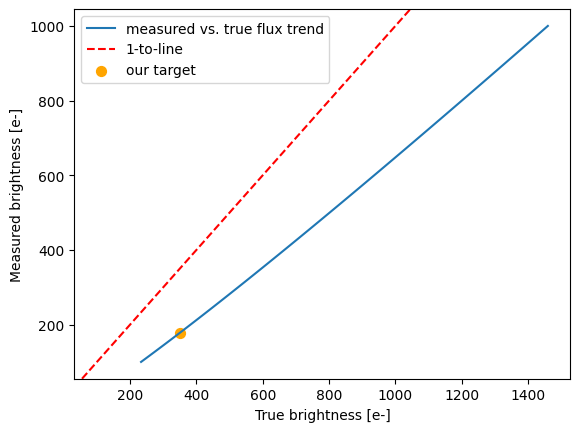

In [26]:
# get source and background counts per exposure
c_true = source_counts / n_frames  # in e-
background_per_exposure = background_counts / n_frames / aperture_area  # in e-/pixel

print(f'expected source counts per exposure = {c_true:.1f}')
print(f'background per pixel per exposure = {background_per_exposure:.1f}')

# now run the function to estimate the CTE-impacted measured brightness
aperture_radius = 5  # aperture radius in pixels. Can be 3 or 5.
estimate_uncorrected_brightness(aperture_radius, y_transfers, mjd, 
                                background_per_exposure, c_true)

With 2000 pixel transfers, we expect pretty significant losses. In this case, the 7.5e-19 erg/s/cm^2/A/arcsec^2 target looks more like a 3.8e-19 erg/s/cm^2/A/arcsec^2 target. If we plug in this new surface brightness and our integration time of 3040 seconds, <a href="https://etc.stsci.edu/etc/results/ACS.im.2252295/">we get an expected SNR of around 5</a>.

We again caution that a fully-vetted extended source correction algorithm has not yet been developed for ACS/WFC. Consider the above results with caution. However, if your science involves analysis of spatially resolved regions of galaxies, it would be prudent to place your target as close to the serial registers as possible.

<a id="additional"></a>

## Additional Resources

- [ACS CTE website](https://www.stsci.edu/hst/instrumentation/acs/performance/cte-information)

<a id="about"></a>

## About this Notebook

**Author:** David V. Stark, Senior Staff Scientist, ACS/HST Team

**Updated On:** 2025-12-05

<a id="citations"></a>

## Citations

If you use Python packages for published research, please cite the
authors. Follow these links for more information about citing `numpy`, `matplotlib`, and `acstools`.

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `matplotlib`](https://matplotlib.org/stable/project/citing.html)
* [Citing `actools`](https://ui.adsabs.harvard.edu/abs/2020ascl.soft11024L/abstract)



***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 